# Imports: 

In [222]:
import pandas as pd
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

import sklearn
import xgboost

import re

In [178]:
cols = sns.color_palette("tab10")

In [185]:
def classifier(X, y, model, shuffle):

    n_splits = 5
    n_classes = 2
    list_roc_auc = [] # store median roc_auc for each regularization parameter
    
    if model == 'logreg':
        reg_param_list = np.array([1e-2, 1e-1, 1e0, 1e1]) # l1 regularization
    elif model == 'xgbc':
        reg_param_list = np.array([10, 100])
    
    # shuffle or don't shuffle y
    y_shfl = y.copy()
    if shuffle: 
        random.shuffle(y_shfl)

    for reg_param_temp in reg_param_list:   # For each regularization parameter: 
        roc_auc = [] #store auc_roc for each fold

        if model == 'logreg':
            clf = LogisticRegression(penalty='l1', solver='liblinear', C=reg_param_temp) # you don't need the multiclass
            # clf = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=reg_param_temp)
        elif model == 'xgbc':
            clf = XGBClassifier(gamma = reg_param_temp, reg_alpha=1, reg_lambda=1, eval_metric='logloss', use_label_encoder=False)

        skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y_shfl[train_index], y_shfl[test_index]
            X_train, y_train = SMOTE().fit_resample(X_train, y_train) # understand this step. 
            # fit model
            clf.fit(X_train, y_train)
            # predict on test set
            y_hat = clf.predict(X_test)
            # evalute classification score using AU-ROC   
            y_pred = clf.predict_proba(X_test)
            roc_auc.append(roc_auc_score(y_test, y_pred[:, 1]))

        list_roc_auc.append( np.median(roc_auc) )
        
            
    df_accuracy = pd.DataFrame()
    df_accuracy['C_reg'] = reg_param_list
    df_accuracy['roc_auc'] = list_roc_auc

    return df_accuracy

In [188]:
def plot_real_vs_shuffled_metric_many(df_true_vs_shlf, C, model, cols, xymin = 0.35, xymax = 0.85):

    df_C = df_true_vs_shlf[df_true_vs_shlf.C_reg == C]
    plt.figure(figsize=(7,7))
    plt.scatter(df_C.metric_true, df_C.metric_shfl_mean, color = cols[-3], s=100, edgecolors='k', linewidths=2)
    plt.errorbar(df_C.metric_true, df_C.metric_shfl_mean, 
                 yerr = [df_C.metric_shfl_mean-df_C.metric_shfl_pc5, df_C.metric_shfl_pc95-df_C.metric_shfl_mean], 
                 fmt = '.', markersize=1, capsize=5, ecolor='k')

    xyline = np.linspace(xymin, xymax, 100)
    plt.xlim(xymin, xymax)
    plt.ylim(xymin, xymax)
    plt.plot(xyline, xyline, 'k--')

    plt.title('logistic regression, C = '+str(C), fontsize = 18)
    plt.xlabel('classification score (AU-ROC)', fontsize = 18)
    plt.ylabel('classification score (AU-ROC)\nrandomized', fontsize = 18)

    xt = plt.xticks(fontsize = 14)
    yt = plt.yticks(fontsize = 14)
    plt.tight_layout()
    # save to file: 
#     path_fig = '../figures/Adrian_classification/'
#     fn_fig = 'true_vs_shuffle_MANY'+metric+'_'+model+'_C_'+str(C)+'_'+version+'.png'
#     plt.savefig(os.path.join(path_fig, fn_fig), dpi = 250)

# Load files:

Classification into substrates: 

In [180]:
# fn = '../data/tests/df_hub_metabolites.csv'
fn = '../data/tests/df_clus_y.csv'
df_class = pd.read_csv(fn)

# df_y.loc[df_y.Rv_ID == 'Rv3423', 'Rv_ID'] = 'Rv3423c'
df_class.loc[df_class.Rv_ID == 'Rv2922', 'Rv_ID'] = 'Rv2922A'

df_class.shape

(860, 42)

TnSeq database: 

In [182]:
# version = 'old'
version = 'clare_basis'
# version = 'clare_all'

# if version == 'old':
#     fn = 'lfc_mb_filt_OLD.csv' ## data set without Claire's screens
# elif version == 'clare_all':
#     fn = 'lfc_mb_filt.csv' ## data set with all of Claire's pairwise combinations
if version == 'clare_basis':
    fn = 'result_logfc_matrix_2021_08_27_BASIS.csv' ## data set only Claire's mutant vs. wildtype screens

path = '../data/standardized_data/'
df_lfc = pd.read_csv(os.path.join(path, fn))
df_lfc.dropna(axis = 0, inplace=True)

df_lfc.shape

(3971, 126)

Annotation database:

In [223]:
file_in = '../data/annotations/uniprot-proteome_UP000001584.tab'
df_annot = pd.read_csv(file_in, sep = '\t')
# Add RvIDs:
re_str = 'Rv\d\d\d\dc?'
list_rvids = [re.findall(re_str, str_temp)[0] for str_temp in df_annot['Gene names']]
df_annot['Rv_ID'] = list_rvids

# Train classifier: 

### Prepare X and y arrays:

X

In [183]:
df_lfc_train = df_lfc[df_lfc.Rv_ID.isin(df_class.Rv_ID)].copy()
df_lfc_train.reset_index(inplace = True, drop = True)

cols_data = df_lfc_train.columns[1:-1]
X = df_lfc_train[cols_data].to_numpy()

X.shape

(857, 124)

y

In [184]:
# cols_chebi = [col for col in df_class.columns if 'CHEBI' in col]
cols_chebi = [col for col in df_class.columns if 'cluster' in col]
df_y = df_lfc_train[['Rv_ID']].merge(df_class, on = 'Rv_ID', how = 'left')[['Rv_ID']+cols_chebi].copy()
print(df_y.Rv_ID.tolist() == df_lfc_train.Rv_ID.tolist())
print(df_y.shape)
df_y.head(2)

True
(857, 28)


,Rv_ID,cluster_10,cluster_23,cluster_3,cluster_0,cluster_9,cluster_13,cluster_5,cluster_1,cluster_4,...,cluster_8,cluster_24,cluster_6,cluster_26,cluster_12,cluster_21,cluster_15,cluster_17,cluster_11,cluster_7
0,Rv0009,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Rv0013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


How many 1's in each cluster? 

In [242]:
list_num_ones = [df_y[df_y[col] == 1].shape[0] for col in cols_chebi]
df_num_ones = pd.DataFrame()
df_num_ones['cluster'] = cols_chebi
df_num_ones['num_ones'] = list_num_ones
list_cols = df_num_ones[df_num_ones.num_ones >= 30].cluster.tolist()
list_cols

['cluster_10',
 'cluster_23',
 'cluster_3',
 'cluster_0',
 'cluster_9',
 'cluster_13',
 'cluster_5',
 'cluster_1',
 'cluster_4',
 'cluster_18',
 'cluster_2',
 'cluster_22',
 'cluster_14',
 'cluster_19',
 'cluster_25',
 'cluster_8',
 'cluster_6',
 'cluster_12',
 'cluster_15']

In [ ]:
df_true_vs_shlf = pd.DataFrame()
model = 'logreg'
metric = 'roc_auc'

for col in list_cols: # For each compound-hub:
    print(col)
    # col = cols_chebi[0]
    # true accuracy
    shuffle = False 
    y = df_y[col].values
    df_accuracy = classifier( X, y, model, shuffle )
    # df_accuracy['compound'] = [col]*df_accuracy.shape[0]
    # df_accuracy = df_accuracy[['compound', 'C_reg', 'roc_auc']]
    # df_accuracy_all = pd.concat([df_accuracy_all, df_accuracy])

    # accuracy after permutation
    shuffle = True 
    num_iter = 50
    list_df_accuracy_SHFL = []

    # col = 'CHEBI_57540-OR-CHEBI_57945-OR-CHEBI_57783-OR-CHEBI_58349'
    for ii in range(num_iter):
        print(ii, 'out of', num_iter)
        try:
            df_accuracy_SHFL = classifier(X, y, model, shuffle)
            list_df_accuracy_SHFL.append(df_accuracy_SHFL)
        except:
            continue

    # Store accuracies of true and shuffled datasets: 
    list_metric_true = []
    list_metric_shfl_pc95 = []
    list_metric_shfl_pc5 = []
    list_metric_shfl_mean = []
    list_pval = []

    list_C = df_accuracy.C_reg.unique()
    for C in list_C:
        metric_true = df_accuracy[df_accuracy.C_reg==C][metric].values[0]
        list_metric_shfl = [ df[df.C_reg == C][metric].values[0] for df in list_df_accuracy_SHFL ]
        # error bars: 
        metric_shfl_pc95 = np.percentile(list_metric_shfl, 95)
        metric_shfl_pc5 = np.percentile(list_metric_shfl, 5)
        metric_shfl_mean = np.median(list_metric_shfl)
        list_metric_true.append(metric_true)
        list_metric_shfl_pc95.append(metric_shfl_pc95)
        list_metric_shfl_pc5.append(metric_shfl_pc5)
        list_metric_shfl_mean.append(metric_shfl_mean)
        list_pval.append(len([met for met in list_metric_shfl if met >= metric_true]) / len(list_metric_shfl))

    df_true_vs_shfl_temp = pd.DataFrame()
    df_true_vs_shfl_temp['compound'] = [col]*len(list_metric_true)
    df_true_vs_shfl_temp['model'] = [model]*len(list_metric_true)
    df_true_vs_shfl_temp['C_reg'] = list_C
    df_true_vs_shfl_temp['metric_true'] = list_metric_true
    df_true_vs_shfl_temp['metric_shfl_pc95'] = list_metric_shfl_pc95
    df_true_vs_shfl_temp['metric_shfl_pc5'] = list_metric_shfl_pc5
    df_true_vs_shfl_temp['metric_shfl_mean'] = list_metric_shfl_mean
    df_true_vs_shfl_temp['pval'] = list_pval

    df_true_vs_shlf = pd.concat([df_true_vs_shlf, df_true_vs_shfl_temp], axis=0)

In [245]:
df_true_vs_shlf.head(1)

,compound,model,C_reg,metric_true,metric_shfl_pc95,metric_shfl_pc5,metric_shfl_mean,pval
0,cluster_10,logreg,0.01,0.545225,0.559202,0.461762,0.495479,0.15


In [253]:
df_true_vs_shlf.shape

(76, 9)

In [255]:
df_true_vs_shlf['diff'] = df_true_vs_shlf.metric_true - df_true_vs_shlf.metric_shfl_mean
df_true_vs_shlf.sort_values(by = 'diff', ascending=False).head(10)

,compound,model,C_reg,metric_true,metric_shfl_pc95,metric_shfl_pc5,metric_shfl_mean,pval,diff
0,cluster_15,logreg,0.01,0.759259,0.587845,0.396264,0.488276,0.000000,0.270984
2,cluster_25,logreg,1.00,0.724224,0.604026,0.423032,0.507690,0.000000,0.216534
1,cluster_15,logreg,0.10,0.709877,0.587154,0.407915,0.507875,0.000000,0.202002
1,cluster_25,logreg,0.10,0.661208,0.613748,0.409435,0.491194,0.000000,0.170014
1,cluster_19,logreg,0.10,0.648148,0.590820,0.447164,0.502288,0.000000,0.145860
0,cluster_1,logreg,0.01,0.663655,0.635484,0.385697,0.519164,0.000000,0.144491
0,cluster_8,logreg,0.01,0.651082,0.625412,0.375191,0.513141,0.020000,0.137942
1,cluster_14,logreg,0.10,0.635697,0.559271,0.438064,0.498153,0.000000,0.137544
3,cluster_1,logreg,10.00,0.639394,0.602304,0.400600,0.502976,0.020408,0.136418
0,cluster_19,logreg,0.01,0.632973,0.572344,0.465275,0.500000,0.000000,0.132973


In [260]:
C = 1e-2
df_true_vs_shlf[(df_true_vs_shlf.C_reg == C) & (df_true_vs_shlf.pval<0.02)]

,compound,model,C_reg,metric_true,metric_shfl_pc95,metric_shfl_pc5,metric_shfl_mean,pval,diff
0,cluster_1,logreg,0.01,0.663655,0.635484,0.385697,0.519164,0.0,0.144491
0,cluster_2,logreg,0.01,0.592063,0.557531,0.458516,0.493608,0.0,0.098456
0,cluster_19,logreg,0.01,0.632973,0.572344,0.465275,0.500000,0.0,0.132973
0,cluster_15,logreg,0.01,0.759259,0.587845,0.396264,0.488276,0.0,0.270984


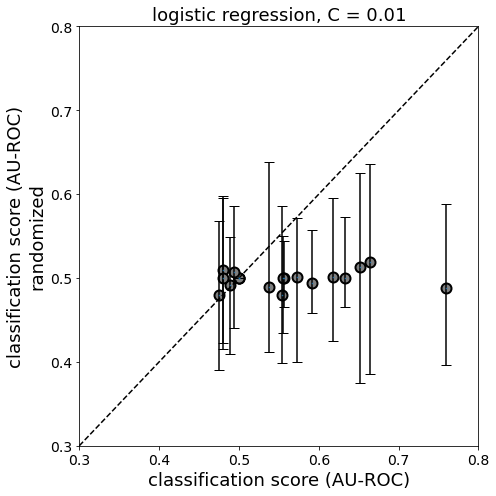

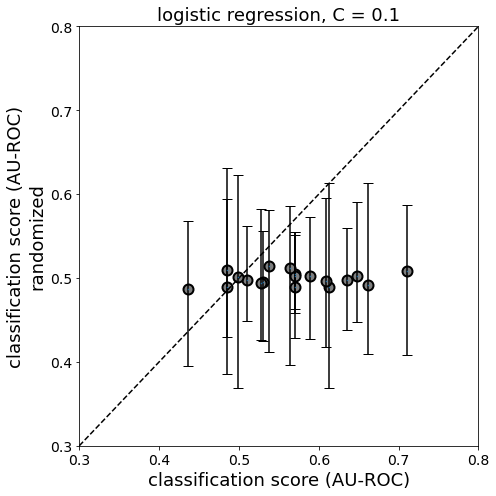

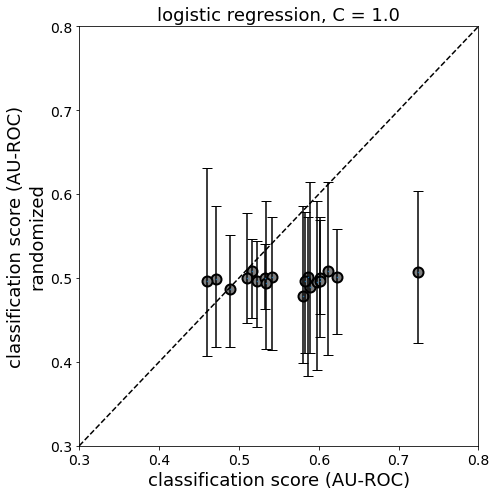

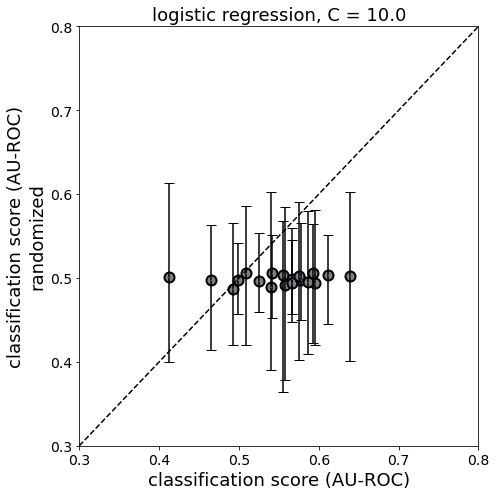

In [254]:
for C in df_true_vs_shlf.C_reg.unique():
    plot_real_vs_shuffled_metric_many(df_true_vs_shlf, C, model, cols, xymin = 0.3, xymax = 0.8)

Who are cluster 15 and 25?

In [226]:
df_annot.columns

Index(['Entry', 'Entry name', 'Status', 'Protein names', 'Gene names',
       'Organism', 'Length', 'Annotation', 'Rhea ID', 'EC number',
       'Catalytic activity', 'ChEBI', 'Sequence', 'Function [CC]', 'Rv_ID'],
      dtype='object')

In [237]:
clus = 14
col = 'cluster_'+str(clus)
list_rvid = df_y[df_y[col]==1].Rv_ID.tolist()
df_annot_clus = df_annot[df_annot.Rv_ID.isin(list_rvid)][['Entry', 'Rv_ID', 'Function [CC]']].copy()
# for func in df_annot_clus['Function [CC]'].tolist():
for index, row in df_annot_clus.iterrows():
    print(row.Entry, row.Rv_ID, ':')
    print(row['Function [CC]'], '\n''\n')

P9WHM9 Rv0772 :
nan 


P9WFV3 Rv1536 :
FUNCTION: Catalyzes the attachment of isoleucine to tRNA(Ile). As IleRS can inadvertently accommodate and process structurally similar amino acids such as valine, to avoid such errors it has two additional distinct tRNA(Ile)-dependent editing activities. One activity is designated as 'pretransfer' editing and involves the hydrolysis of activated Val-AMP. The other activity is designated 'posttransfer' editing and involves deacylation of mischarged Val-tRNA(Ile) (By similarity). {ECO:0000250}.; FUNCTION: Confers high-level resistance to the antibiotic mupirocin (pseudomonic acid A), an Ile-analog that competitively inhibits activation by Ile-tRNA synthetase, thus inhibiting protein biosynthesis. 


P9WHN7 Rv1014c :
FUNCTION: The natural substrate for this enzyme may be peptidyl-tRNAs which drop off the ribosome during protein synthesis. {ECO:0000255|HAMAP-Rule:MF_00083}. 


I6YG32 Rv3420c :
FUNCTION: N-alpha-acetyltransferase that specifically medi

In [194]:
df_true_vs_shlf.groupby('compound').mean().sort_values(by = 'metric_true', ascending=False)

,C_reg,metric_true,metric_shfl_pc95,metric_shfl_pc5,metric_shfl_mean
compound,,,,,
cluster_25,2.7775,0.649689,0.564778,0.413831,0.489338
cluster_19,2.7775,0.625194,0.542077,0.451377,0.497034
cluster_14,2.7775,0.609558,0.556735,0.488827,0.524623
cluster_1,2.7775,0.581818,0.580180,0.383575,0.468129
cluster_3,2.7775,0.580574,0.658438,0.474772,0.523216
cluster_2,2.7775,0.563736,0.567017,0.475713,0.510854
cluster_0,2.7775,0.553380,0.527651,0.491221,0.512680
cluster_4,2.7775,0.548706,0.566303,0.453529,0.522789
cluster_10,2.7775,0.548369,0.536844,0.447824,0.495194
